In [1]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

%load_ext sql
conn = duckdb.connect()
%sql duckdb:///:memory:
%sql conn --alias duckdb

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

Connecting to 'duckdb:///:memory:'

In [2]:
%%sql
CREATE TABLE Riders             AS FROM "../data/riders.csv";
CREATE TABLE RiderTeams         AS FROM "../data/rider_teams.csv";
CREATE TABLE Managers           AS FROM "../data/managers.csv";
CREATE TABLE ManagerTeams       AS FROM "../data/manager_teams.csv";
CREATE TABLE ManagerTeamsCheapo AS FROM "../data/manager_cheapo_teams.csv";
CREATE TABLE PointsSystem       AS FROM "../data/points_system.csv";
CREATE TABLE Races              AS FROM "../data/races.csv";
CREATE TABLE Results_2023       AS FROM "../data/results/results_2023_full.csv";
CREATE TABLE Results_2024       AS FROM "../data/results/results_2024_full.csv";
CREATE TABLE Results_2025       AS FROM "../data/results/results_2025_full.csv";
CREATE TABLE CheapoBans         AS FROM "../data/cheapo_bans.csv";

,Count
0,14


In [3]:
%%sql
CREATE OR REPLACE TABLE RaceResultsPoints AS
SELECT
     results.Race
    ,races.RaceName
    ,races.RaceCategory
    ,results.Stage_ID
    ,COALESCE(results.Stage_Date, races.RaceStart) AS Stage_Date
    ,results.Stage_Type
    ,CASE WHEN results.Stage_ID <> 'gc' AND (results.Stage_Type <> 'TTT' OR results.Stage_Type IS NULL) THEN 1 ELSE 0 END AS Løbsdage
    ,results.Rider AS RiderName_PCS
    ,riders.RiderName_Zweeler
    ,riders.RiderPrice
    ,riders.RiderTeam
    ,CASE WHEN cbans.RiderName IS NULL AND riders.RiderPrice <= 2.5 THEN 'Ja' ELSE '' END AS Cheapo
    ,results.Rank
    ,points.RacePoints AS Points
    ,CASE WHEN races.RaceName = 'Tour Down Under' THEN NULL Else points.RacePoints END AS CheapoPoints
FROM Riders riders
LEFT JOIN Results_2025 results ON results.Rider = riders.RiderName_PCS
LEFT JOIN Races races ON races.RaceName_PCS = results.Race
LEFT JOIN CheapoBans cbans ON cbans.RiderName = riders.RiderName_Zweeler
LEFT JOIN PointsSystem points ON 1 = 1
    AND (results.Stage_Type IS NULL OR results.Stage_Type <> 'TTT')
    AND points.RaceRank = TRY_CAST(results.Rank AS INTEGER) 
    AND CASE WHEN results.Stage_ID LIKE '%stage%' THEN REPLACE(races.RaceCategory, 'Tour', 'Stage') ELSE races.RaceCategory END = points.RaceCategory;

,Count
0,28412


In [4]:
%%sql
df <<
WITH Datoer AS
(
    SELECT DISTINCT Stage_Date
    FROM RaceResultsPoints
    WHERE 1 = 1
        # AND Points > 0
), RankedDatoer AS
(
    SELECT Stage_Date, ROW_NUMBER() OVER(ORDER BY Stage_Date ASC) AS RN
    FROM Datoer
), RaceResultsManagers AS
(
    SELECT 
         results.Stage_Date
        ,results.Points
        ,teams.ManagerName
    FROM RaceResultsPoints results
    INNER JOIN ManagerTeams teams ON teams.RiderName = results.RiderName_Zweeler
    INNER JOIN Datoer dd ON dd.Stage_Date = results.Stage_Date
    WHERE 1 = 1
        AND Points > 0
)
SELECT 
     src.RN AS Løbsdag
    ,src.Stage_Date
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Chrelle'), 0) AS INTEGER) AS Chrelle
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Kenk'), 0) AS INTEGER) AS Kenk
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Knak'), 0) AS INTEGER) AS Knak
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Matti'), 0) AS INTEGER) AS Matti
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Okholm'), 0) AS INTEGER) AS Okholm
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Jappo'), 0) AS INTEGER) AS Jappo
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Hustlersen'), 0) AS INTEGER) AS Hustlersen
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Jarma'), 0) AS INTEGER) AS Jarma
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Visti'), 0) AS INTEGER) AS Visti
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Tommy'), 0) AS INTEGER) AS Tommy
FROM RankedDatoer src
ORDER BY RN;

In [5]:
%%sql
df <<
WITH Datoer AS
(
    SELECT DISTINCT Stage_Date
    FROM RaceResultsPoints
    WHERE 1 = 1
        AND Points > 0
), RankedDatoer AS
(
    SELECT Stage_Date, ROW_NUMBER() OVER(ORDER BY Stage_Date ASC) AS RN
    FROM Datoer
), RaceResultsManagers AS
(
    SELECT 
         results.Stage_Date
        ,results.Points
        ,teams.ManagerName
    FROM RaceResultsPoints results
    INNER JOIN ManagerTeams teams ON teams.RiderName = results.RiderName_Zweeler
    INNER JOIN Datoer dd ON dd.Stage_Date = results.Stage_Date
    WHERE 1 = 1
        AND Points > 0
)
SELECT 
     src.RN AS Løbsdag
    ,src.Stage_Date
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Chrelle'), 0) AS INTEGER) AS Chrelle
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Kenk'), 0) AS INTEGER) AS Kenk
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Knak'), 0) AS INTEGER) AS Knak
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Matti'), 0) AS INTEGER) AS Matti
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Okholm'), 0) AS INTEGER) AS Okholm
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Jappo'), 0) AS INTEGER) AS Jappo
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Hustlersen'), 0) AS INTEGER) AS Hustlersen
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Jarma'), 0) AS INTEGER) AS Jarma
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Visti'), 0) AS INTEGER) AS Visti
    ,CAST(COALESCE((SELECT SUM(res.Points) FROM RaceResultsManagers res WHERE res.Stage_Date <= src.Stage_Date AND res.ManagerName = 'Tommy'), 0) AS INTEGER) AS Tommy
FROM RankedDatoer src
ORDER BY RN;

In [6]:
%%sql
WITH Datoer AS
(
    SELECT DISTINCT Stage_Date
    FROM RaceResultsPoints
    WHERE 1 = 1
        AND Points > 0
), RankedDatoer AS
(
    SELECT Stage_Date, ROW_NUMBER() OVER(ORDER BY Stage_Date ASC) AS RN
    FROM Datoer
), RaceResultsManagers AS
(
    SELECT 
         results.Stage_Date
        ,extract('week' from results.Stage_Date) AS Uge
        ,results.Points
        ,teams.ManagerName AS Manager
    FROM RaceResultsPoints results
    INNER JOIN ManagerTeams teams ON teams.RiderName = results.RiderName_Zweeler
    INNER JOIN Datoer dd ON dd.Stage_Date = results.Stage_Date
    WHERE 1 = 1
        AND Points > 0
        AND ManagerName IN ('Okholm', 'Chrelle')
), ResultsPrWeek AS
(
    SELECT
        Uge
        ,CAST(SUM(CASE WHEN Manager = 'Chrelle' THEN Points END) AS int) AS Chrelle
        ,CAST(SUM(CASE WHEN Manager = 'Okholm' THEN Points END) AS int) AS Okholm
    FROM RaceResultsManagers
    GROUP BY Uge
)
SELECT 
     *
    ,CASE 
        WHEN Chrelle = Okholm THEN 'Uafgjort'
        WHEN Chrelle > Okholm THEN 'Chrelle'
        ELSE 'Okholm'
     END AS Vinder
    ,ABS(Chrelle - Okholm) AS Pointforskel    
FROM ResultsPrWeek
WHERE Uge >= 18
ORDER BY Uge;

,Uge,Chrelle,Okholm,Vinder,Pointforskel
0,18,234,186,Chrelle,48
1,19,207,48,Chrelle,159
2,20,215,70,Chrelle,145
3,21,218,75,Chrelle,143
4,22,115,399,Okholm,284
5,23,47,45,Chrelle,2
6,24,392,573,Okholm,181
7,25,587,202,Chrelle,385
8,27,76,101,Okholm,25
9,28,366,514,Okholm,148


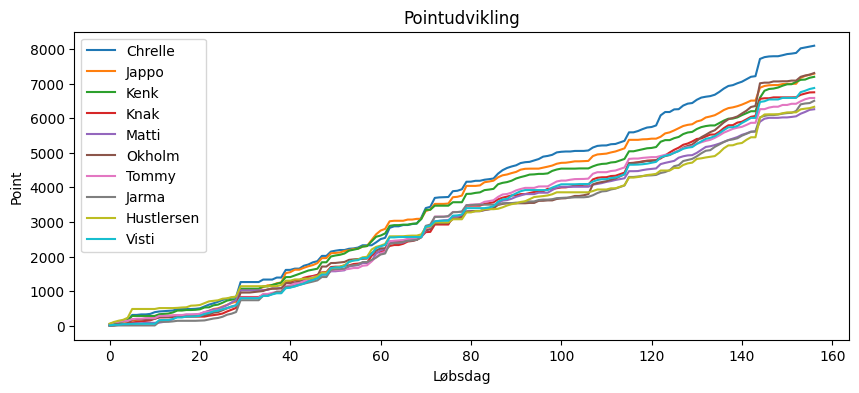

In [7]:
plt.figure(figsize=(10, 4))  # Wider chart: 12 units wide, 4 units tall

#plot individual lines
plt.plot(df['Chrelle'], label = 'Chrelle')
plt.plot(df['Jappo'], label = 'Jappo')
plt.plot(df['Kenk'], label = 'Kenk')
plt.plot(df['Knak'], label = 'Knak')
plt.plot(df['Matti'], label = 'Matti')
plt.plot(df['Okholm'], label = 'Okholm')
plt.plot(df['Tommy'], label = 'Tommy')
plt.plot(df['Jarma'], label = 'Jarma')
plt.plot(df['Hustlersen'], label = 'Hustlersen')
plt.plot(df['Visti'], label = 'Visti')

plt.title("Pointudvikling")
plt.xlabel("Løbsdag")
plt.ylabel("Point")

plt.legend()
plt.show()

In [8]:
%%sql
    SELECT DISTINCT Stage_Date
    FROM RaceResultsPoints
    WHERE 1 = 1
        AND Points > 0
        AND Stage_Date >= '2025-05-01'

,Stage_Date
0,2025-05-15
1,2025-05-02
2,2025-05-03
3,2025-05-24
4,2025-05-29
...,...
70,2025-08-08
71,2025-08-09
72,2025-08-21
73,2025-08-22
